#  Simulation of outbreak of COVID-19 in an enclosed environment (Version 2)

We aim to simulate the outbreak of COVID-19 in an enclosed environment such an FPSO (Floating Production Storage and Offloading) in which 

* Everyone is susceptible and has the same probability of being affected
* One of the individuals carries the SARS-CoV-2 virus but does not show any symptom when the simulation starts
* By default anyone who shows symptom will be removed from the population (or quarantined, as long as he or she can no longer infect others), the simulation allows keeping symptomatic cases in the population to simulate un-managed populations.

The simulation aims to answer questions such as

* The epidemic curve when one infected case arrives in the population.
* When the first symptomatic case appears, and if and when the second symptomatic case will appear.
* If someone shows symptom on the third day, how likely he or she is the index case.
* How likely the outbreak will start again if no one shows symptom after the first symptomatic case is removed.

## Changes since version 1

According to recent studies, asymptomatic transmissions could play a significant role in the transmission of COVID-19 virus. The reported proportions of asymptomatic virus carriers vary greatly and the real impact is largely unknown. However, the implication of wide-spread asymptomatic transmission is that self-quarantine might not be as effective as we have estimated. This updated report tries to quantify the magnitude of this change.

Previous simulations assumed that the index cases (seed carriers) are always at the beginning of their incubation periods when they are introduced to the population. This was potentially biased because they could be anywhere in their incubation period as long as they do not show symptom before they are dispatched. The updated simulations allow optional lead incubation period.

## Major challenge

The major challenge in this study is that we have very limited knowledge on the role of pre-symptomatic transmission, which is the main concern of this study. According to CDC's FAQ on ["how COVID spreads"](https://www.cdc.gov/coronavirus/2019-ncov/prevent-getting-sick/how-covid-spreads.html) and ["when some is infectious"](https://www.cdc.gov/coronavirus/2019-ncov/hcp/faq.html), and an article from [Yuan, et al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7074995/):

1. People are thought to be most contagious when they are most symptomatic (the sickest).
2. Some spread might be possible before people show symptoms; there have been reports of this occurring with this new coronavirus, but this is not thought to be the main way the virus spreads.  
3. The onset and duration of viral shedding and period of infectiousness for COVID-19 are **not yet known**. Asymptomatic infection with SARS-CoV-2 has been reported, but it is not yet known what role asymptomatic infection plays in transmission. Similarly, the role of pre-symptomatic transmission (infection detection during the incubation period prior to illness onset) is unknown.
4. Based on previous studies of influenza viruses and community-acquired human coronaviruses, the viral loads in asymptomatic carriers are relatively low.

We tested several transmissibility (disease infectivity) models and **the results show that asymptomatic and pre-symptomatic infection plays a major role in the spread of COVID-19**.

## Assumptions

Basic assumptions,

* There are $N$ individuals, including one newly-introduced virus carrier
* everyone is susceptible
* symptomatic people are quarantined and removed

In addition to the basic assumptions of number of individuals and the removal of symptomatic individuals, we will make the following assumptions (best guesses) based on existing literatures:


* A distribution of incubation period (before symptoms appear) with a mean of 5.1 days  and range from 2 to 11 days.
* A reproduction number $R_0$ between 1.4 and 2.8, which is the expected number of individuals the carrier will infect if he or she is not removed from the population. Note that $R_0$ is not a fixed number and is the average number of a population. It will vary from population to population, and over time with changing parameters such as social distancing.
* Some mathematical models for infectivity before symptoms, based on the assumption that the **carrier becomes increasingly contagious** over time, and an overall R0 throughout an infectious period of 7-12 days ([Wu et al.](https://doi.org/10.1016/S0140-6736(20)30260-9)) if the carrier is not removed.
* **(new)** Virus carrier could show no symptom throughout their course of infection, but their infectiousness (transmissibility) would be much smaller than symptomatic carriers.

### Distribution of incubation period

According to [Lauer et al.](https://annals.org/aim/fullarticle/2762808/incubation-period-coronavirus-disease-2019-covid-19-from-publicly-reported) and [their later update](https://www.jwatch.org/na51083/2020/03/13/covid-19-incubation-period-update), estimated median incubation time (IT) of COVID-19 was 5.1 days; mean IT was 5.5 days. For 97.5% of infected persons, symptoms appear by 11.5 days. Fewer than 2.5% are symptomatic within 2.2 days. Estimated median IT to fever was 5.7 days. This estimate has been used by a [recent Science paper](https://science.sciencemag.org/content/early/2020/03/30/science.abb6936).

Our simulated incubation period follows this distribution.

#### Tech details

According to [this reference](https://github.com/HopkinsIDD/ncov_incubation), the distribution could be modeled by different distributions, with small differences in the shape of distribution. The authors chose to use a lognormal model with parameters `1.621` and `0.418`. The `2.5%`, `50%`, and `97.5%` quantile for incubation time are `2.2`, `5.05`, and `11.5` days, respectively.

In [76]:
import numpy as np

incubation_period = np.random.lognormal(mean=1.621, sigma=0.418, size=10000)
np.quantile(incubation_period, q=[0.025, 0.5, 0.975])

array([ 2.22814544,  5.02558832, 11.4157195 ])

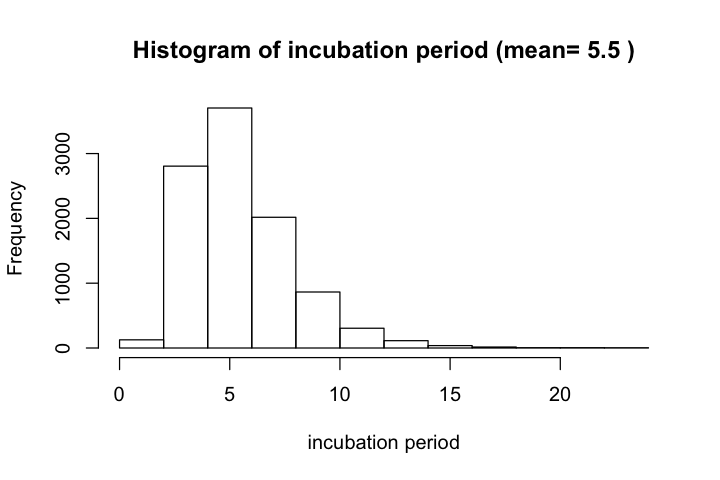

In [77]:
%get incubation_period
library(repr)

options(repr.plot.width=6, repr.plot.height=4)

hist(incubation_period, xlab='incubation period',
    main=paste('Histogram of incubation period (mean=',
              round(mean(incubation_period), 1), ')'))

### Serial interval

Serial interval is defined as the days between the primary case (infector) developing symptoms and secondary case (infectee) developing symptoms. According to [Nishiura et al](https://www.sciencedirect.com/science/article/pii/S1201971220301193?via%3Dihub), the mean serial interval for COVID-19 is 4.6 days with confidence interval between 3.5 and 5.9 days. These estimates agree largely with results from other sources such as [Du et al](https://www.medrxiv.org/content/10.1101/2020.02.19.20025452v3.full.pdf), which reported that the mean interval was 3.96 days (95% CI 3.53–4.39 days), SD 4.75 days (95% CI 4.46–5.07 days); 12.6% of case reports indicated presymptomatic transmission.

Negative serial intervals were observed for COVID-19, meaning that the infectee developed symptoms before the infector, supporting the role of pre-symptomatic transmission.

**We use the distributions of serial intervals to validate our models** because serial intervals are combined results of incubation and virus transmission.

#### Technical details

[Du et al](https://www.medrxiv.org/content/10.1101/2020.02.19.20025452v3.full.pdf) used a distribution of `N(3.96, 4.75)`, with `(3.53, 4.39)` as the 95% CI for mean, and `(4.46, 5.07)` as the 95% CI for standard deviation. This distribution is more realistic than the lognormal models used by other authors, who followed the traditional assumpion of positive serial intervals.

Data from Du et al has `12.6%` cases of negative serial intervals, which is less than the 20% percent of negative intervals as `N(3.86, 4.75)` indicates. We will use both quantities to validate our results. 

In [78]:
from scipy.stats import norm

# quantiles
serial_intervals = np.random.normal(loc=3.96, scale=4.75, size=10000)
np.quantile(serial_intervals, q=[0.025, 0.5, 0.975])

array([-5.45908985,  3.98873037, 13.33131496])

In [79]:
# percent of negative serial intervals
norm(3.96, 4.75).cdf(0)

0.2022294789782194

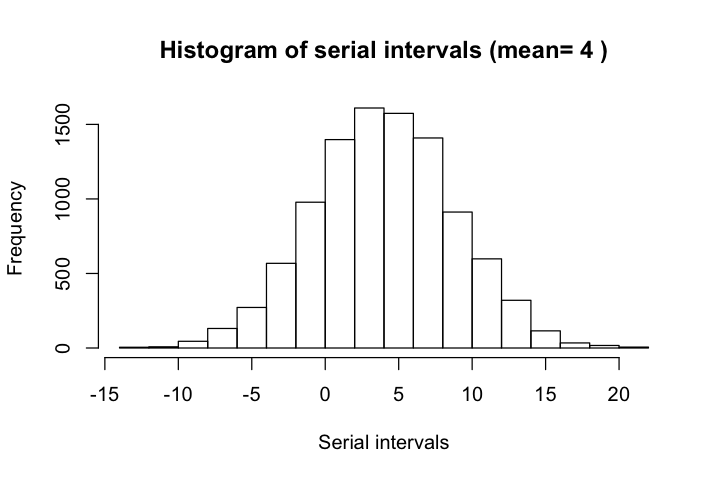

In [80]:
%get serial_intervals

hist(serial_intervals, xlab='Serial intervals',
    main=paste('Histogram of serial intervals (mean=',
              round(mean(serial_intervals), 1), ')'))

### Asymptomatic transmission (new)

According to recent studies, asymptomatic transmission, names transmissions from virus carriers who will never show any symptom or show only mild symptoms that perhaps resemble allergy, plays a non-significant, but non-negligible role in the transmission of COVID-19 virus ([reports](https://www.sciencealert.com/here-s-what-we-know-so-far-about-those-who-can-pass-corona-without-symptoms)). Although true asymptomatic transmissions have been identified (e.g. [Bai et al](https://jamanetwork.com/journals/jama/fullarticle/2762028), [Mizumoto et al](https://www.eurosurveillance.org/content/10.2807/1560-7917.ES.2020.25.10.2000180)), most patients who carried the virus and showed no symptom during testing showed symptoms after a while (75% in a week). The proportion of "true" asymptomatic carriers was reported to be `17.9%` from the Diamond Pincess cruise ship [Mizumoto et al](https://www.eurosurveillance.org/content/10.2807/1560-7917.ES.2020.25.10.2000180), `25%` as estimated by [CDC](https://www.sciencealert.com/here-s-what-we-know-so-far-about-those-who-can-pass-corona-without-symptoms), and `40%` from a recent mathematical model published in Science ([Ferretti et al](https://science.sciencemag.org/content/early/2020/03/30/science.abb6936)).


The infectiousness of these asymptomatic carriers are estimated to be much lower than symptomatic carriers. [Liu et al.](https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30232-2/fulltext) reported that the mean viral load of severe cases was around 60 times higher than that of mild cases, suggesting that higher viral loads might be associated with severe clinical outcomes. Mild cases were found to have an early viral clearance, with 90% of these patients repeatedly testing negative on RT-PCR by day 10 post-onset. By contrast, all severe cases still tested positive at or beyond day 10 post-onset. [Ferretti et al](https://science.sciencemag.org/content/early/2020/03/30/science.abb6936) models the relative infectiousness of asymptomatic infectors is 1/10 of symptomatic infectors. With an extremely high percentage of asymptomatic cases (40%) in that model, about `6%` of all infectees were estimated to be infected by asymptomatic carriers. This number has not been confirmed by any other studies.

Because of the proportions of asymptomatic carriers are largely unknown and tend to change from population to population, **we will assume the proportion of asymptomatic carriers follow a random distribution with mean of 25%, and a 95% confidence interval between 10% and 40%**.

### Generation time (new)

The generation time is defined for source-recipient transmission pairs as the time between the infection of the source and the infection of the recipient. Because serial interval equals ($t_2$ + $i_2$) - ($t_1$ + $i_1$) = ($t_2$ - $t_1$) + ($i_2$ - $i_1$) = generation time + ($i_2$ - $i_1$) where $t$ and $i$ are infection and incubation times, generation time are usually estimated from serial interval, but should be always positive and have smaller variance.

[Ferretti et al](https://science.sciencemag.org/content/early/2020/03/30/science.abb6936) chose to estimate generation time directly and modeled the distribution of generation time with Weibull distribution with mean and median equal to 5.0 days and standard deviation of 1.9 days. The estimated mean generation time is larger than mean serial number (~4.0 days) reported elsewhere so **we will compare but will not try to adjust our simulations to match the estimated distribution**.

#### Technical details

Distribution of generation time, according to Table 1 of [Ferretti et al](https://science.sciencemag.org/content/early/2020/03/30/science.abb6936)  follows a Weibull distribution with parameters (2.826 and 5.665)

In [81]:
gt = 5.665 * np.random.weibull(2.826,  10000)

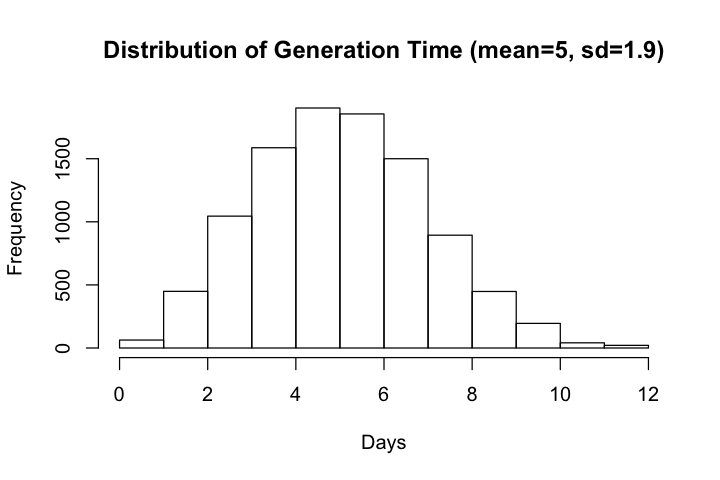

In [82]:
%get gt
hist(gt, main=paste0('Distribution of Generation Time (mean=', round(mean(gt), 1),
                     ", sd=", round(sd(gt), 1), ')'), xlab='Days')

### Proportions of asymptomatic, pre-symptomatic and sympatomatic transmissions (new)

[Ferretti et al](https://science.sciencemag.org/content/early/2020/03/30/science.abb6936) have also estimated  the fraction of pre-symptomatic, symptomatic, environmental, and asymptomatic infections to be 47%, 38%, 10%, and 6% respectively (table 2), with the assumption of 40% of virus carriers will not show any symptom. Our model does not consider environmental infections because environmental exposures on a FPSO vessel is expected to be much lower than in a more open environment. **We aim to provide realistic proportions of asymptomatic and pre-symptomatic transmissions because symptomatic individuals are promptly removed from the environment.**.

### Modeling Transmissibility (version 1, updated to validation generation time and proportions of pre-asympomatic transmission)

There are very few study on the infectivity of COVID-19 at this point. [Wolfel et al](https://www.medrxiv.org/content/10.1101/2020.03.05.20030502v1.full.pdf) provided a detailed virological analysis of nine cases. They showed that the patients already have high RNA concentrations in throat swab, actually already on a declining stage when they were admitted with symptoms. The only good news was that live virus isolation were unsuccessful after day 8 in spite of ongoing high viral loads, so the patients were no longer infectious.

More and more studies have shown evidence of asymptomatic transmission so we tried several models of transmissibility with varying levels of asymptomatic transmission. We tried a constant model where infectors demonstrate constant transmissbility as well as a linear model where infectors demonstrate linearly increasing transmissibility. However, **none of the models yielded results that agreed with the observed serial transmissions.**.

Based on these experiments, we developed a model that assumes that **the transmissibility peaks at onset of symptoms, and declines before and after onset, following a normal distribution with 95% of infectivity happens in 14 days.** The distribution is truncated at left-hand side dpending on incubation period, and is scaled to have a total infectibity of R0, which is uniformly distributed from 1.4 to 2.8.


#### Technical details

For example, if the incubation period of a carrier is 4 days, and R0=2.2, the transmissibility is calculated as follows:

In [83]:
from scipy.stats import norm

In [84]:
def TransProbV1(incu, R0, interval=1/24):
    '''Transmission probability.    
    incu
        incubation period in days (can be float)
        
    R0
        reproductive number, which is the expected number of infectees
        
    interval
        interval of simulation, default to 1/24, which is by hours    
    
    returns
    
      x
          time point
      y
          probability of transmission for each time point
    '''
    x = np.linspace(0, incu + 14, (incu+14)/interval)
    dist = norm(incu, 3.572)
    y = dist.pdf(x)
    sum_y = sum(y)
    return x, y / sum(y) * R0

The following curve shows hourly probability of transmission from day 0 to 18, with a incubation period of 4.0 days, and a cummulative $R_0$ of 2.2.

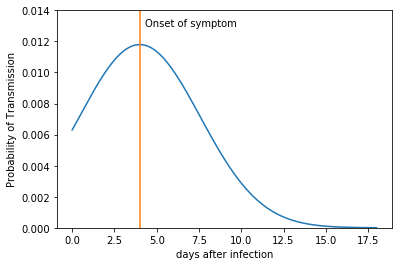

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt

x,y = TransProbV1(4, 2.2)
plt.plot(x, y)
plt.plot([4, 4], [0, 0.014])
plt.ylim(0, 0.014)
plt.xlabel('days after infection') 
plt.text(4.3, 0.013, 'Onset of symptom')
plt.ylabel('Probability of Transmission')
plt.show()

#### Model validation

We simulated 10000 replicates of the transmissibility of an individual using the following scenario:
    
1. Incubationn periods drawn from a log normal distribution
2. $R_0$ dawn from a uniform distributed from 1.4 to 2.8

For every simulation,

1. The transmission probability is calculated as described above
2. A binomial distribution is applied at each hour to simulate the transmission of virus to another person. Overall number of infectees are recorded.
3. Incubation periods of infectees are drawn from the same log normal distribution
4. Serial intervals are calculated as the symptom date between the infector and infectee

In [93]:
def rand_incu(size=1):
    return np.random.lognormal(mean=1.621, sigma=0.418, size=size)

In [102]:
def InfectV1(incu, R0, interval=1/24):
    x, p = TransProbV1(incu, R0, interval)
    infected = np.random.binomial(1, p, len(x))
    presymptomatic_infected = len([xx for xx, ii in zip(x, infected) if ii and xx < incu])
    symptomatic_infected = len([xx for xx, ii in zip(x, infected) if ii and xx >=incu])
    n_infected = sum(infected)
    if n_infected > 0:
        first = list(infected).index(1)*interval
        symp = first + rand_incu()[0]
        si = symp - incu
        return n_infected, presymptomatic_infected, symptomatic_infected, si, first
    else:
        return 0, 0, 0, 0, 0


In [103]:
N = 10000

incubation_period = rand_incu(size=N)
R0 = np.random.uniform(1.4, 2.8, size=N)

all_r0 = []
all_r = []
all_r_presym = []
all_r_sym = []
all_si = []
all_gt = []
for incu, r0 in zip(incubation_period, R0):
    all_r0.append(str(int(r0*10)/10))
    r, r_presym, r_sym, si, gt = InfectV1(incu, r0)
    all_r.append(r)
    all_r_presym.append(r_presym)
    all_r_sym.append(r_sym)
    all_si.append(si)
    all_gt.append(gt)

In [104]:
%get all_r0 all_r all_r_presym all_r_sym all_si all_gt
all_r = as.numeric(all_r)
all_r_presym = as.numeric(all_r_presym)
all_r_sym = as.numeric(all_r_sym)
all_si = as.numeric(all_si)
all_gt = as.numeric(all_gt)

The following table shows the mean number of infectees, and the mean, standard deviation, and. 5%, 50%, 95% quantiles of serial intervals.


In [105]:
library(plyr)
library(dplyr)
df=data.frame(R0=as.factor(all_r0), r=all_r, r_presym=all_r_presym, r_sym=all_r_sym, si=all_si, gt=all_gt)
df = df[df$r != 0, ]
ddply(df, .(R0), function(x) 
      { c(mean_r0=mean(x$r), 
        mean_r_presym=mean(x$r_presym),
        mean_r_sym=mean(x$r_sym),
        mean_si=mean(x$si),
        sd_si=sd(x$si),
        mean_gt=mean(x$gt),
        sd_gt=sd(x$gt),
        prop_neg=sum(x$si<0)/length(x$si),
        si=quantile(x$si, 0.05),
        si=quantile(x$si, 0.5),
        si=quantile(x$si, 0.95)
        ) })

R0,mean_r0,mean_r_presym,mean_r_sym,mean_si,sd_si,mean_gt,sd_gt,prop_neg,si.5%,si.50%,si.95%
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.4,1.903108,0.8482633,1.054845,4.753616,3.933297,5.019119,3.440872,0.09323583,-0.8015589,4.646304,11.44049
1.5,1.925046,0.8427788,1.082267,5.113096,3.879161,4.964580,3.474193,0.06764168,-0.4271830,4.583863,11.97305
1.6,2.037255,0.8588235,1.178431,4.847015,3.800270,4.894935,3.584202,0.07843137,-0.4812798,4.308298,11.72158
1.7,2.134991,0.8987567,1.236234,4.745763,3.874228,4.679322,3.337108,0.10657194,-1.6251864,4.635583,11.99354
1.8,2.166392,0.9555189,1.210873,4.597345,3.675292,4.619371,3.367546,0.08401977,-0.8704088,4.320796,11.44078
1.9,2.235679,1.0425532,1.193126,4.728030,3.988033,4.659574,3.648090,0.09165303,-0.7272284,4.111468,11.91260
2.0,2.389671,1.1079812,1.281690,4.368828,3.730093,4.442423,3.373992,0.10641628,-0.9444872,3.987094,11.16504
2.1,2.438168,1.0412214,1.396947,4.381575,3.523978,4.317684,3.345369,0.10381679,-1.0617410,4.099220,10.62833
2.2,2.476336,1.1511450,1.325191,4.319486,3.517561,4.347201,3.449518,0.08549618,-0.6439329,4.044216,10.27638


With this transmissibility model, the mean number of infectees agree with specified $R_0$ quite well. The distributions of serial intervals has mean=`4.4` and sd=`3.7`, which are largely consistent with the `N(3.96, 4.75)` distribution from 
[Du et al](https://www.medrxiv.org/content/10.1101/2020.02.19.20025452v3.full.pdf). The percent of negative serial intervals is actually smaller than what is expected the normal distribution (`20%`) and agrees better with the empirical data (`12.6%` to `16.35`).


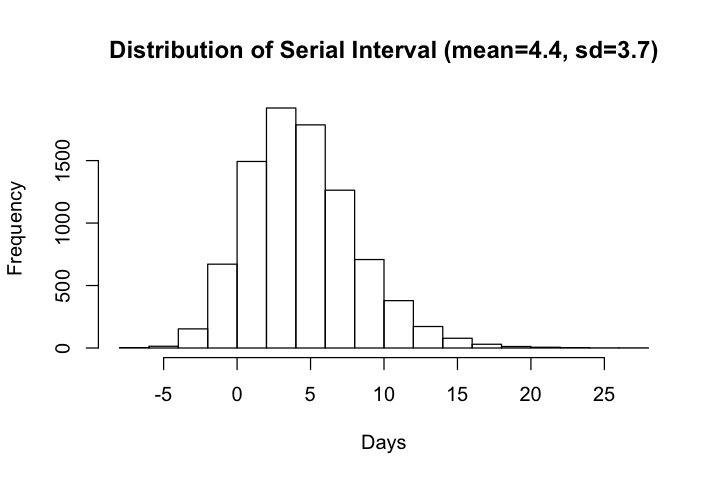

In [106]:
hist(df$si, main=paste0('Distribution of Serial Interval (mean=', round(mean(df$si), 1),
            ", sd=", round(sd(df$si), 1), ')'), xlab='Days', breaks=20)

Due to our choice of a truncated normal distribution, the distribution of generation time does not follow a Weibull distribution, and have a mean of `4.4` days and std of `3.3` days. 

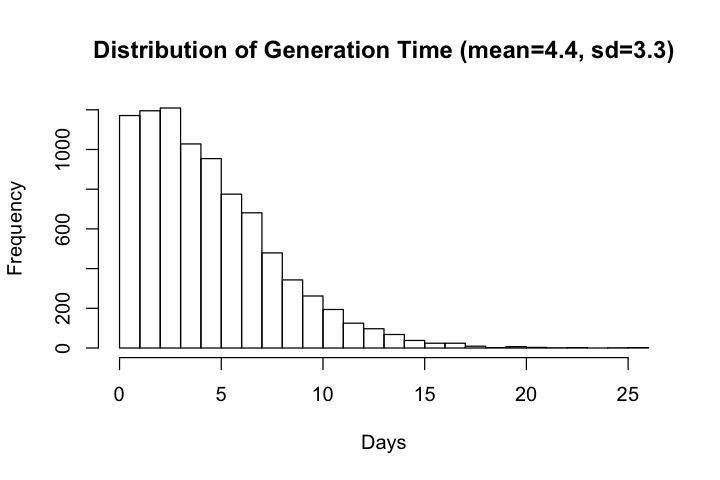

In [110]:
df_gt = df[]
hist(df$gt, main=paste0('Distribution of Generation Time (mean=', round(mean(df$gt), 1),
            ", sd=", round(sd(df$gt), 1), ')'), xlab='Days', breaks=20)

In [111]:
rp = sum(df$r_presym)
rs = sum(df$r_sym)
rp / (rp + rs)
rs / (rp + rs)

[1] 0.4466793

[1] 0.5533207

The overall proportion of pre-symptomatic and symptomatic infections are `44%` and `56%`, which largely agrees with [Ferretti et al](https://science.sciencemag.org/content/early/2020/03/30/science.abb6936) (`47%` pre-symptomatic, `38%` symptomatic) since this model does not consider asymptomatic infection and environmental infection (`16%`).

### Modeling Transmissibility (version 2, with asymptomatic transmission and adjusted transmissibility model)

The first version of the transmissbility model generates simulations with realistic interval time, but it does not consider asymptomatic transmission. Because the transmissibility distribution is left-truncated with a relatively high probability of transmissibility at the time of virus contact, the distribution of generation time does not match observed distributions. In addition, the proportion of pre-asymptomatic transmission is lower than what was estimated by [Ferretti et al](https://science.sciencemag.org/content/early/2020/03/30/science.abb6936), which is more than `50%` if we only consider presymptomatic and symptomatic transmissions (`47%` vs `38%` respectively, scale to `55%` vs `45%` if we only consider these two cases.

We revised this model in the following ways:

1. For each replicated simulation, we allow a proportion of asymptomatic infectors. The proportion ranges from 10% to 40% following a random distribution centered at 25%.

2. Asymptomatic infectors will not show any symptom. They will have an overall production number ranging from `0.28` to `0.56`, in contrast to `1.4` to `2.8` for symptomatic transmissions. This 5 fold reduction is smaller than the 10 fold reduction suggested by [Ferretti et al](https://science.sciencemag.org/content/early/2020/03/30/science.abb6936) but we believe that the gap between asymptomatic and symptomatic infectors should be smaller and should be even modeled with a continuous distribution for the two cases because the line between asymptomatic and symptomatic infectors can be quite blurred and there is no justification for the gap of $R_0$.

3. According to various reports ([CDC](https://www.cdc.gov/mmwr/volumes/69/wr/mm6913e1.htm), [ScienceAlert](
https://www.sciencealert.com/here-s-what-we-know-so-far-about-those-who-can-pass-corona-without-symptoms), and a study on [Singapore cases](https://www.cdc.gov/mmwr/volumes/69/wr/mm6914e1.htm?s_cid=mm6914e1_w)), people infected and experience no symptoms or very mild symptoms may have very high viral load for the first few days, and that most presymptomatic transmission exposure occurred one to three days before a person developed symptoms. We therefore shifted the peak of the transmissbility distribution to 2/3 of the incubation date.

#### Technical details

In [2]:
import numpy as np
from scipy.optimize import bisect
from scipy.stats import norm

In [1]:
def rand_incu(size=1):
    return np.random.lognormal(mean=1.621, sigma=0.418, size=size)

In [3]:
sd_6 = bisect(lambda x: norm.cdf(14, loc=6, scale=x) - 0.975, a=0.001, b=5)

def TransProb(incu, R0, interval=1/24):
    '''Transmission probability.    
    incu
        incubation period in days (can be float)
        
    R0
        reproductive number, which is the expected number of infectees
        
    interval
        interval of simulation, default to 1/24, which is by hours    
    
    returns
    
      x
          time point
      y
          probability of transmission for each time point
    '''
    # right side with 6 day interval
    incu = incu * 2 / 3
    dist_right = norm(incu, sd_6)
    # left hand side with a incu day interval
    sd_left = bisect(lambda x: norm.cdf(2*incu, loc=incu, scale=x) - 0.99, a=0.001, b=15, xtol=0.001)
    dist_left = norm(incu, sd_left)
    scale = dist_right.pdf(incu) / dist_left.pdf(incu)   
    x = np.linspace(0, incu + 10, int((incu+10)/interval))
    idx = int(incu / interval)
    y = np.concatenate([dist_left.pdf(x[:idx])*scale, dist_right.pdf(x[idx:])])
    sum_y = sum(y)
    return x, y / sum(y) * R0

In [4]:
sd_5 = bisect(lambda x: norm.cdf(10, loc=5, scale=x) - 0.995, a=0.001, b=5)

def AsympTransProb(R0, interval=1/24):
    '''Asymptomatic Transmission probability.    
    R0
        reproductive number, which is the expected number of infectees
        
    interval
        interval of simulation, default to 1/24, which is by hours    
    
    returns
    
      x
          time point
      y
          probability of transmission for each time point
    '''
    dist = norm(4.8, sd_5)
    x = np.linspace(0, 12, int(12/interval))
    y = dist.pdf(x)
    sum_y = sum(y)
    return x, y / sum(y) * R0

For example, if the incubation period of a carrier is 4 days, and $R_0$=2.2, the probability of transmission for each day is shown below (in blue). A similar curve for asymptomatic transmission with $R_0$=0.22 is also plotted (in orange). The distribution of asymptomatic transmission has a normal distribution centered at 5 days. 

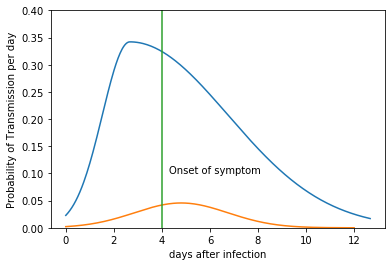

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

x, y = TransProb(4.0, 2.2)
x1, y1 = AsympTransProb(0.22)
plt.plot(x, y*24)
plt.plot(x1, y1*24)
plt.plot([4, 4], [0, 0.40])
plt.text(4.3, 0.10, 'Onset of symptom')
plt.ylim(0, 0.4)
plt.xlabel('days after infection') 
plt.ylabel('Probability of Transmission per day')
plt.show()

#### Model validation

We simulated 10000 replicates of the transmissibility of an individual using the following scenario:
    
1. Incubationn periods drawn from a log normal distribution
2. $R_0$ dawn from a uniform distributed from 1.4 to 2.8

For every simulation,

1. The transmission probability is calculated as described above
2. A binomial distribution is applied at each hour to simulate the transmission of virus to another person. Overall number of infectees are recorded.
3. Incubation periods of infectees are drawn from the same log normal distribution
4. Serial intervals are calculated as the symptom date between the infector and infectee

In [15]:
def Infect(incu, R0, interval=1/24):
    if incu == -1:
        # asymptomatic
        x, p = AsympTransProb(R0, interval)
    else:
        x, p = TransProb(incu, R0, interval)
    infected = np.random.binomial(1, p, len(x))
    if incu == -1:
        asymptomatic_infected = sum(infected)
        presymptomatic_infected = 0
        symptomatic_infected = 0
    else:
        asymptomatic_infected = 0
        presymptomatic_infected = len([xx for xx, ii in zip(x, infected) if ii and xx < incu])
        symptomatic_infected = len([xx for xx, ii in zip(x, infected) if ii and xx >=incu])
    n_infected = sum(infected)
    if n_infected > 0:
        first = list(infected).index(1)*interval
        if np.random.uniform(0, 1) < 0.25:
            # new case is asymptomatic
            si = -99
        elif incu == -1:
            # old case is asymptomatic
            si = -99
        else:
            symp = first + rand_incu()[0]
            si = symp - incu
        return n_infected, asymptomatic_infected, presymptomatic_infected, symptomatic_infected, si, first
    else:
        return 0, 0, 0, 0, -99, 0


In [26]:
N = 100000

P_asym = 0.25

N_asymptomatic = int(N*P_asym)
N_regular = N - N_asymptomatic

incubation_period = np.concatenate([rand_incu(size=N_regular), np.full(N_asymptomatic, -1)])
R0 =  np.concatenate([np.random.uniform(1.4, 2.8, size=N_regular), 
                      np.random.uniform(1.4/5, 2.8/5, size=N_asymptomatic)])


all_r0 = []
all_r = []
all_r_asym = []
all_r_presym = []
all_r_sym = []
all_si = []
all_gt = []
for incu, r0 in zip(incubation_period, R0):
    all_r0.append(f'{round(r0, 1):.1f}')
    r, r_asym, r_presym, r_sym, si, gt = Infect(incu, r0)
    all_r.append(r)
    all_r_asym.append(r_asym)
    all_r_presym.append(r_presym)
    all_r_sym.append(r_sym)
    all_si.append(si)
    all_gt.append(gt)

In [27]:
%get all_r0 all_r all_r_asym all_r_presym all_r_sym all_si all_gt
all_r = as.numeric(all_r)
all_r_asym = as.numeric(all_r_asym)
all_r_presym = as.numeric(all_r_presym)
all_r_sym = as.numeric(all_r_sym)
all_si = as.numeric(all_si)
all_gt = as.numeric(all_gt)

The following table shows the mean number of asymptomatic, presymptomatic, and symptomatic production numbers for different $R_0$ values. The rows with $R_0<0$ are rows with asymptomatic transmissions. 

In [43]:
library(plyr)
library(dplyr)
df=data.frame(R0=as.factor(all_r0), r=all_r, r_asym=all_r_asym, 
              r_presym=all_r_presym, r_sym=all_r_sym, si=all_si, gt=all_gt)
ddply(df, .(R0), function(x) 
      { c(mean_r0 = mean(x$r),
        mean_r_asym=mean(x$r_asym),
        mean_r_presym=mean(x$r_presym),
        mean_r_sym=mean(x$r_sym)
        )})

R0,mean_r0,mean_r_asym,mean_r_presym,mean_r_sym
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0.3,0.3114241,0.3114241,0.0000000,0.0000000
0.4,0.4109496,0.4109496,0.0000000,0.0000000
0.5,0.4994408,0.4994408,0.0000000,0.0000000
0.6,0.5462963,0.5462963,0.0000000,0.0000000
1.4,1.4075691,0.0000000,0.7045124,0.7030568
1.5,1.4730740,0.0000000,0.7636500,0.7094241
1.6,1.5893382,0.0000000,0.8180147,0.7713235
1.7,1.6594393,0.0000000,0.8407477,0.8186916
1.8,1.8183161,0.0000000,0.9697194,0.8485968


Generation time is only available for simulations with at least one infectee. The distributio of generation time generally decreased with incraese produciton time ($R_0$), and have a overall mean of `4.1` and standard devitation of `2.5`.

R0,mean_gt,sd_gt
<fct>,<dbl>,<dbl>
0.3,4.603998,1.907061
0.4,4.627946,1.863005
0.5,4.570048,1.913478
0.6,4.284923,1.966402
1.4,4.490594,2.716685
1.5,4.445273,2.754045
1.6,4.495428,2.651129
1.7,4.307651,2.632217
1.8,4.155815,2.629038


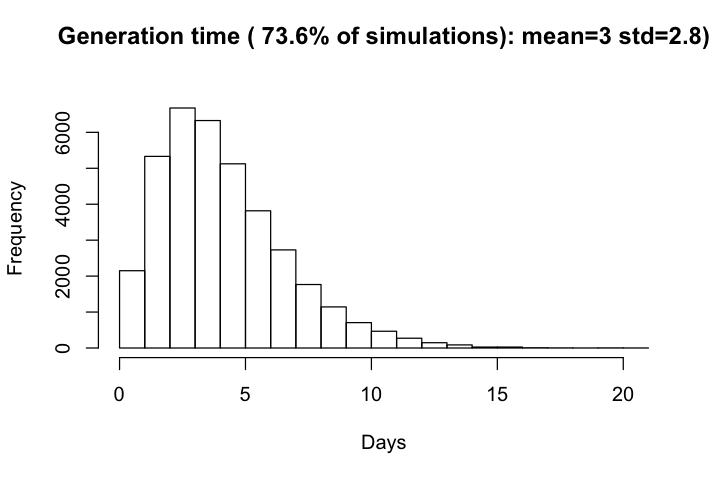

In [52]:
all_row = dim(df)[1]
df_r = df[df$r > 0, ]
row_with_r = dim(df_r)[1]
options(repr.plot.width=6, repr.plot.height=4)

ddply(df_r, .(R0), function(x) 
      { c(
        mean_gt=mean(x$gt),
        sd_gt=sd(x$gt)
        )})

hist(df_r$gt, xlab='Days', main=paste0("Generation time ( ", round(row_with_r/all_row*100, 1),
           "% of simulations): mean=", round(mean(df$gt), 1), " std=", round(sd(df$gt),1), ")\n"))


The distribution of serial intervals has a mean of 4.1 days and standard deviation of 3.7 days. There are overall 12% of negative serial intervals, which agrees well with observed cases.

R0,mean_si,std_si,prec_neg
<fct>,<dbl>,<dbl>,<dbl>
1.4,4.546973,3.764258,0.09068323
1.5,4.420089,3.738917,0.09003215
1.6,4.510535,3.820499,0.09944410
1.7,4.252373,3.796522,0.11000622
1.8,4.059037,3.643867,0.10248987
1.9,4.253474,3.708581,0.10193004
2.0,4.185517,3.648288,0.10229885
2.1,4.159789,3.778120,0.11585366
2.2,4.122831,3.722660,0.10136674


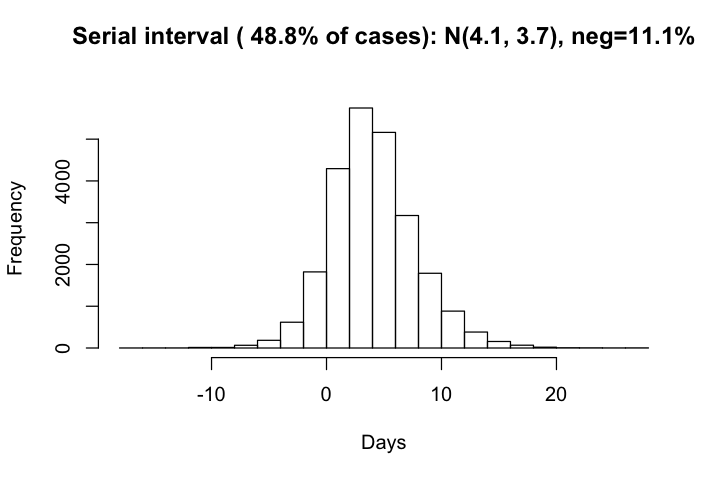

In [63]:
library(plyr)
library(dplyr)

df_si = df_r[df_r$si != -99, ]
row_with_si = dim(df_si)[1]

ddply(df_si, .(R0), function(x) 
      { c(mean_si = mean(x$si),
        std_si=sd(x$si),
        prec_neg=sum(x$si < 0)/length(x$si)
        )})

hist(df_si$si, xlab='Days', main=paste0("Serial interval ( ", round(row_with_si/all_row*100, 1),
           "% of cases): N(", round(mean(df_si$si), 1), ", ", round(sd(df_si$si),1), 
                                       "), neg=",  round(sum(df_si$si<0)*100/row_with_si,1), "%\n"))


The overall proportion of asyptomatic, pre-symptomatic and symptomatic infections are `6%`, `48%` and `46%`, which agrees with [Ferretti et al](https://science.sciencemag.org/content/early/2020/03/30/science.abb6936) (`6%` pre-symptomatic, `47%` pre-symptomatic, `38%` symptomatic) since this model does not consider environmental infection (`16%`).

In [64]:
ra = sum(df$r_asym)
rp = sum(df$r_presym)
rs = sum(df$r_sym)
ra / (rp + rs + ra)
rp / (rp + rs + ra)
rs / (rp + rs + ra)

[1] 0.06283215

[1] 0.4790996

[1] 0.4580682

## Simulation of COVID-19 outbreaks on FPSO vessel (with updated simulator)

Based on the transmisibility model we have developed, we have developed a simulation program `covid19-outbreak-simulator` that simulate the aforementioned scenario at an hourly interval:

1. 64 individuals, with one newly introduced carrier
2. Whoever shows symptom are removed from the vessel
3. Simulation ends when there is no carrier on the vessel, or everyone is infected and eventually removed.

"Repeated infection" events, namely the infection of individuals who are already infected with the virus, are ignored. Although repeated infections could in theory accerlerate the onset of symptom of infectees, they are rare events at the beginning of simulations and should not affect the results of the simulations.

The simulation program also allows for the following options:

1. Keeping of symptomatic individuals, as a way to show what would happen if we allow the virus to spread.
2. Pre-quarantine the crew before he or she is onboard. This allows us to estimate the risk if we send only people who have been in quarantine to FPSO.
3. **new:** Proportion of asymptomatic carriers, which is also the probability that infectees will not show any symptom.
4. **new:** The index case will be asymptomatic but can be at a random point in his or her incubation period. This is different from the previous simulation when the carriers are always considered to be at the beggining of their incubation periods.

Despite the differences in the modeling of transmissibility probabilities, **the new program yields very similar results with the first version when the proportion of asymptomatic carriers is set to zero and without lead incubation period**. 

Results from simulations with lead incubation time are, not surprisingly, better than the first 12 scenarios. The overall probability of having an outbreak of COVID-19 decreased from 70% to 65%, and the effect of 7-day pre-quarantine is almost as good as 14-day quarantine in the previous cases. The inclusion of lead period time changes when the outbreaks start but has no impact on how they develop. 

Just to show the overall results of simulations, the following figures display the duration of outbreak (x-axis) vs the remaining population size (y-axis) for a few scenarios. 

In [23]:
library(ggplot2)
library(ggExtra)

summary_report <- function(data_file, title) {
    data = read.table(data_file, sep='\t', header=1)
    end_count = data[data['event'] == 'END',]
    
    cat(paste('Summary of simulations with parameters ', title, '\n'))
        
    cat(paste0('\nQuantiles of duration of outbreak (mean=', round(mean(end_count$time), 1), 
          ', std=', round(sd(end_count$time), 1), ")\n"))
    
    print(quantile(end_count$time, c(0.025, 0.05, 0.5, 0.95, 0.975)))
    
    title = paste0('\nDuration vs Remaining Popsize (', title, ')')
    
    p <- ggplot(end_count, aes(x=time, y=target)) + geom_point(size=0.2, color='slateblue') + theme(legend.position="none") +
      xlab('Days') + ylab('Remaining Population Size') + ggtitle(title)
    
    p1 <- ggMarginal(p, type="histogram", 
                    xparams=list(bins=120),
                    yparams=list(bins=64),
                    fill = "slateblue",
                    color="slateblue"
                    ) 
    print(p1)    
}


For example, the the first version of the simulation script, there is a clear lognormal shaped distribution for duration of outbreaks, which indicates the first outbreak will happen around 5 days after the introduction of the seed carrier, and there are likely second and third outbreaks.

Summary of simulations with parameters  first model 

Quantiles of duration of outbreak (mean=14.9, std=14.6)
   2.5%      5%     50%     95%   97.5% 
 2.5700  3.0400  9.2250 46.5800 56.9135 


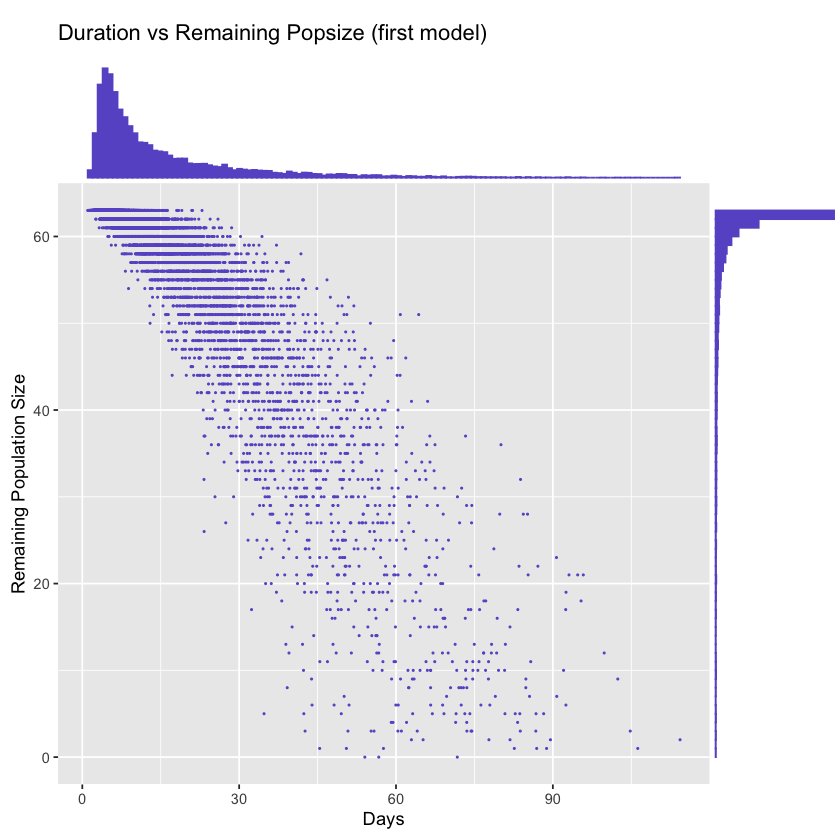

In [35]:
summary_report('simu_remove_symptomatic_v1.log', 'first model')

Simulations from the second version of the models, assuming no asumptomatic transmissions, is similar but more severe than the first version because it has a higher percentage of pre-sympatomatic transmission rate (55% vs 45%), so the intensity of outbreaks are higher, resulting more "wipe-out" scenarios.

Summary of simulations with parameters  revised model, p_asym=0 

Quantiles of duration of outbreak (mean=20.1, std=20.8)
    2.5%       5%      50%      95%    97.5% 
 2.43000  2.86000 10.71000 66.07100 74.69025 


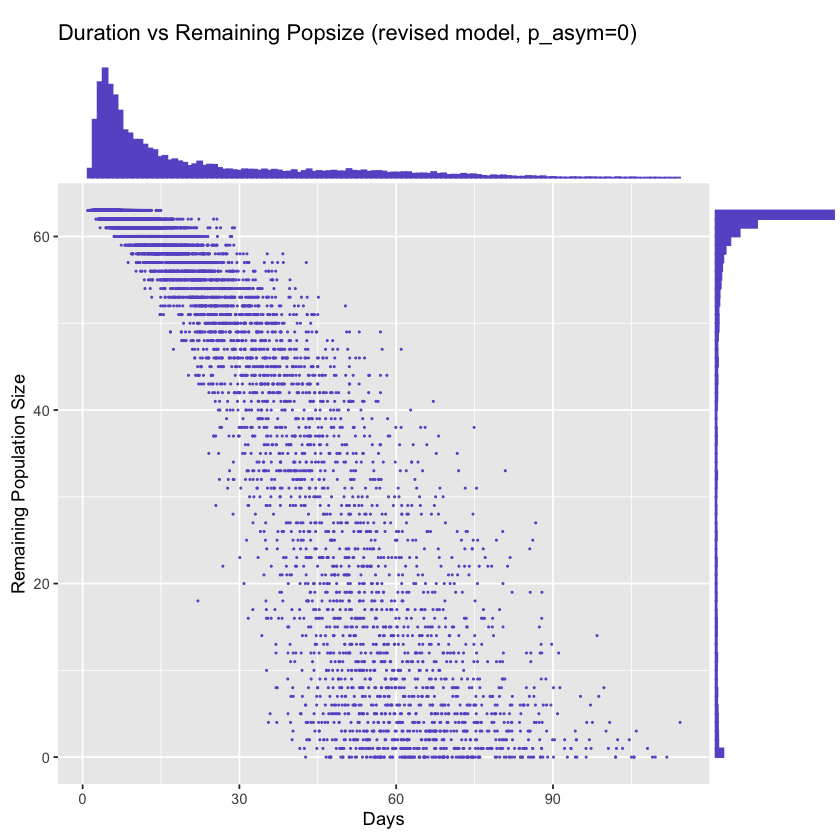

In [36]:
summary_report('simu_FPSO_pasym_0.log', 'revised model, p_asym=0')

The simulations that allow asymptomatic transmissions have the clear spike at the first day. These are around 25% of the simulations with asymptomatic carrier that will not show any symptom and will not affect anyone. The overall severity of the outbreaks are weaker than the ones without asymptomatic carriers.

The distribution of outbreak looks quite different for simulations with lead incubation period, because the carrier will show symptom much sooner than cases without lead incubation time.